In [2]:
DATA_DIR = "D:\\Data\\Kline\\UsdFutures"

TIME_COL = 'OpenTime'
OPEN_COL = 'OpenPrice'
HIGH_COL = 'HighPrice'
LOW_COL = 'LowPrice'
CLOSE_COL = 'ClosePrice'
VOLUME_COL = 'QuoteVolume'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import gc
from statsmodels.tsa.stattools import coint
# If needed for advanced analysis or Johansen cointegration:
# from statsmodels.tsa.vector_ar.vecm import coint_johansen

# 1) Read CSV files
# Adapt the filenames and columns to match your actual data
btc = pd.read_csv(os.path.join(DATA_DIR, 'BTCUSDT.csv'), parse_dates=[TIME_COL])
eth = pd.read_csv(os.path.join(DATA_DIR, 'ETHUSDT.csv'), parse_dates=[TIME_COL])

# 2) Clean & rename columns if needed
# For example, let's rename 'Close' column to indicate clearly:
btc.rename(columns={CLOSE_COL: 'BTC_Close', VOLUME_COL:'BTC_Volume'}, inplace=True)
eth.rename(columns={CLOSE_COL: 'ETH_Close', VOLUME_COL:'ETH_Volume'}, inplace=True)

# 3) Set DateTime index (assuming 'Open time' is the start time for each candle)
btc.set_index(TIME_COL, inplace=True)
eth.set_index(TIME_COL, inplace=True)

# 4) Align data by reindexing on the intersection (or union) of time
combined = pd.merge(btc[['BTC_Close', 'BTC_Volume']],
                    eth[['ETH_Close', 'ETH_Volume']],
                    left_index=True, right_index=True,
                    how='inner')  # or 'outer' if you want all data points
combined.dropna(inplace=True)

# We now have a DataFrame named 'combined' with columns: BTC_Close, BTC_Volume, ETH_Close, ETH_Volume
print(combined.head())

del btc, eth
gc.collect()


C:\Users\Kenneth\AppData\Local\Temp\2\ipykernel_13188\4133370623.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  btc = pd.read_csv(os.path.join(DATA_DIR, 'BTCUSDT.csv'), parse_dates=[TIME_COL])
C:\Users\Kenneth\AppData\Local\Temp\2\ipykernel_13188\4133370623.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  eth = pd.read_csv(os.path.join(DATA_DIR, 'ETHUSDT.csv'), parse_dates=[TIME_COL])


               BTC_Close    BTC_Volume  ETH_Close    ETH_Volume
OpenTime                                                       
1645747200000    38339.2  8.150269e+06    2598.63  7.007570e+06
1645747260000    38284.6  8.865343e+06    2591.81  5.749675e+06
1645747320000    38263.8  1.361943e+07    2591.39  1.228171e+07
1645747380000    38265.2  1.019760e+07    2591.04  3.056329e+06
1645747440000    38280.2  7.546948e+06    2594.05  5.841765e+06


214

## 2. Cointegration-Based Analysis

### 2.1 Engle-Granger Cointegration Test
A simple way to check if BTC and ETH are cointegrated is to run `statsmodels.tsa.stattools.coint`. This will give you a p-value indicating whether the spread is stationary. 

In [4]:
# 1) Engle-Granger test
score, pvalue, _ = coint(combined['BTC_Close'], combined['ETH_Close'])
print(f"Engle-Granger p-value: {pvalue:.5f}")

if pvalue < 0.05:
    print("Likely cointegrated (reject null of no cointegration).")
else:
    print("No strong evidence of cointegration at 5% level.")


Engle-Granger p-value: 0.95637
No strong evidence of cointegration at 5% level.


### 2.2 Building a Spread and Checking Stationarity
If cointegration is confirmed, we can estimate the hedge ratio \(\beta\) (by linear regression of BTC on ETH or vice versa), then form the spread.

Regression Summary:
                            OLS Regression Results                            
Dep. Variable:              BTC_Close   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                 4.694e+06
Date:                Tue, 25 Mar 2025   Prob (F-statistic):               0.00
Time:                        20:57:06   Log-Likelihood:            -1.7085e+07
No. Observations:             1578241   AIC:                         3.417e+07
Df Residuals:                 1578239   BIC:                         3.417e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.733e+04     29.867

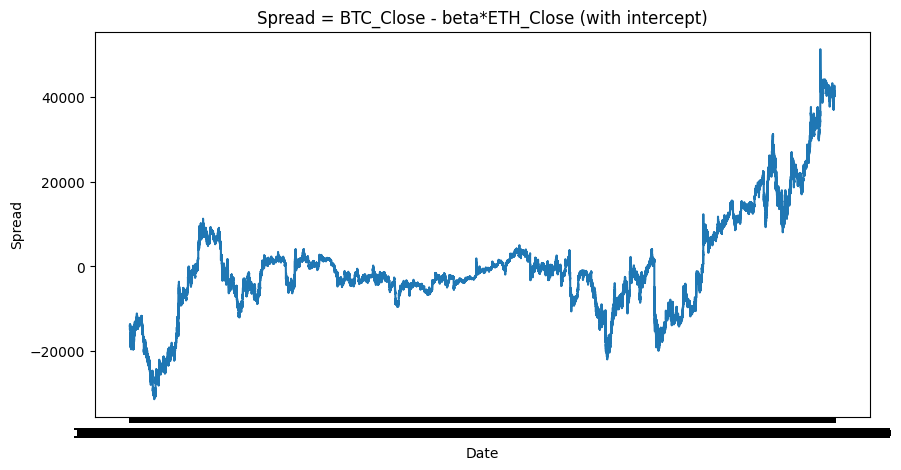

162560802

In [5]:
# 2) Estimate hedge ratio: Regress BTC on ETH
X = sm.add_constant(combined['ETH_Close'])
y = combined['BTC_Close']
model = sm.OLS(y, X).fit()
hedge_ratio = model.params['ETH_Close']
intercept = model.params['const']

print("Regression Summary:")
print(model.summary())
print(f"\nHedge ratio (beta) = {hedge_ratio:.4f}, Intercept = {intercept:.4f}")

# 3) Create the spread: spread = BTC_Close - (hedge_ratio * ETH_Close + intercept)
combined['spread'] = combined['BTC_Close'] - (hedge_ratio * combined['ETH_Close'] + intercept)

# 4) Plot the spread to visualize
plt.figure(figsize=(10, 5))
plt.plot(combined.index, combined['spread'])
plt.title("Spread = BTC_Close - beta*ETH_Close (with intercept)")
plt.xlabel("Date")
plt.ylabel("Spread")
plt.show()

del X, y, model
gc.collect()

If the spread is truly stationary, you’ll often see it oscillate around a mean. You can check its stationarity further with the Augmented Dickey-Fuller (ADF) test:

In [6]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(combined['spread'].dropna())
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

del adf_result
gc.collect()

ADF Statistic: -0.6000795466672577
p-value: 0.8709640515733517


0

### 2.3 Generating Signals (Simple Mean Reversion)
A basic pairs trading approach:

1. Standardize the spread into a z-score:  
   \( z\_score = \frac{spread - \mu}{\sigma} \)  
   (where \(\mu\) and \(\sigma\) are rolling mean and std of the spread).

2. Go **short** spread when \(z\_score\) is > +2 (meaning BTC is relatively expensive vs ETH).  
3. Go **long** spread when \(z\_score\) is < -2.  
4. Exit trades when \(z\_score\) returns to near 0 (or crosses zero).

Below is a simplistic example. Feel free to adjust thresholds to your liking.

C:\Users\Kenneth\AppData\Local\Temp\2\ipykernel_13188\3636775300.py:24: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)


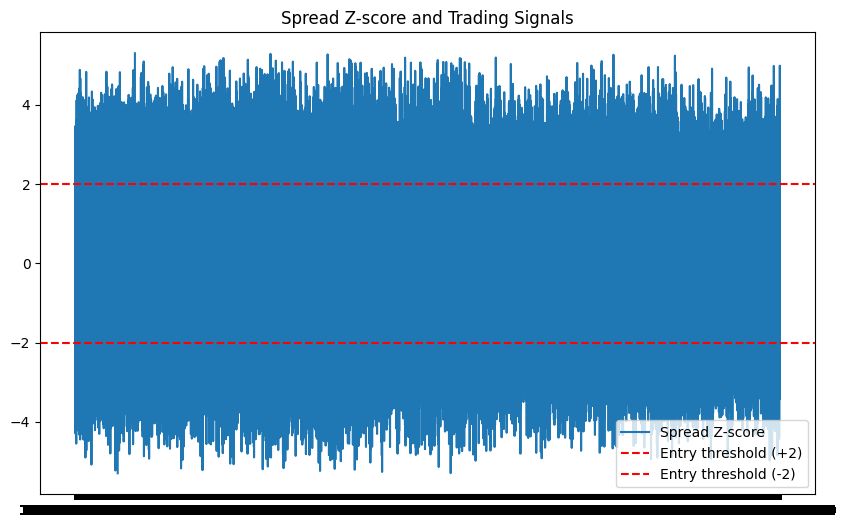

167296214

In [7]:
def zscore(series, window=30):
    return (series - series.rolling(window).mean()) / series.rolling(window).std()

combined['spread_z'] = zscore(combined['spread'], window=30)

# We'll create signals:
entry_threshold = 2.0
exit_threshold  = 0.5

def generate_signals(df):
    df['signal'] = 0
    
    # When z > entry_threshold => short the spread
    df.loc[df['spread_z'] > entry_threshold, 'signal'] = -1
    
    # When z < -entry_threshold => long the spread
    df.loc[df['spread_z'] < -entry_threshold, 'signal'] = 1
    
    # Flatten signal to 0 when z is between -exit_threshold and +exit_threshold
    # This naive approach doesn't handle partial positions but is a simple example
    df.loc[df['spread_z'].abs() < exit_threshold, 'signal'] = 0
    
    # Forward fill the positions so we hold until an exit signal
    df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
    return df

combined = generate_signals(combined)

# Quick visualization
plt.figure(figsize=(10, 6))
plt.title("Spread Z-score and Trading Signals")
plt.plot(combined.index, combined['spread_z'], label='Spread Z-score')
plt.axhline(entry_threshold, color='r', linestyle='--', label='Entry threshold (+2)')
plt.axhline(-entry_threshold, color='r', linestyle='--', label='Entry threshold (-2)')
plt.legend()
plt.show()

gc.collect()

### 2.4 Evaluating Performance (Naive Backtest)
A rough approximation of PnL:

- If position = -1 (short spread), PnL moves in the opposite direction of the spread.  
- If position = +1 (long spread), PnL follows the spread changes.  

We can do a naive differential PnL:

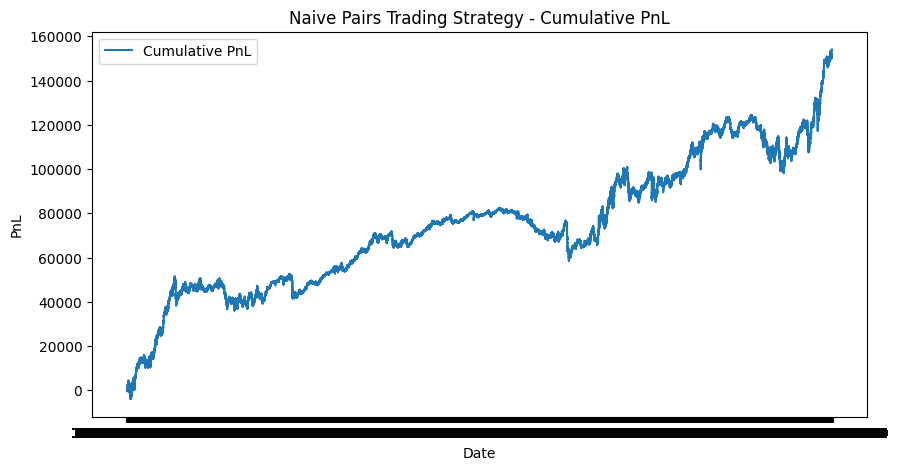

167296286

In [8]:
combined['spread_change'] = combined['spread'].diff()
combined['pnl'] = combined['position'].shift(1) * combined['spread_change']

combined['cumulative_pnl'] = combined['pnl'].cumsum()

plt.figure(figsize=(10, 5))
plt.title("Naive Pairs Trading Strategy - Cumulative PnL")
plt.plot(combined.index, combined['cumulative_pnl'], label='Cumulative PnL')
plt.xlabel('Date')
plt.ylabel('PnL')
plt.legend()
plt.show()

combined.drop(columns=['signal','spread_change','spread_z'], inplace=True)
gc.collect()

## 3. Z-Score Trading (Without Formal Cointegration Check)

Even if you do not test cointegration explicitly, you can still attempt a simpler z-score reversion approach on the **price ratio** or **difference**:

C:\Users\Kenneth\AppData\Local\Temp\2\ipykernel_13188\498435456.py:12: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position_ratio'] = df['signal_ratio'].replace(to_replace=0, method='ffill')


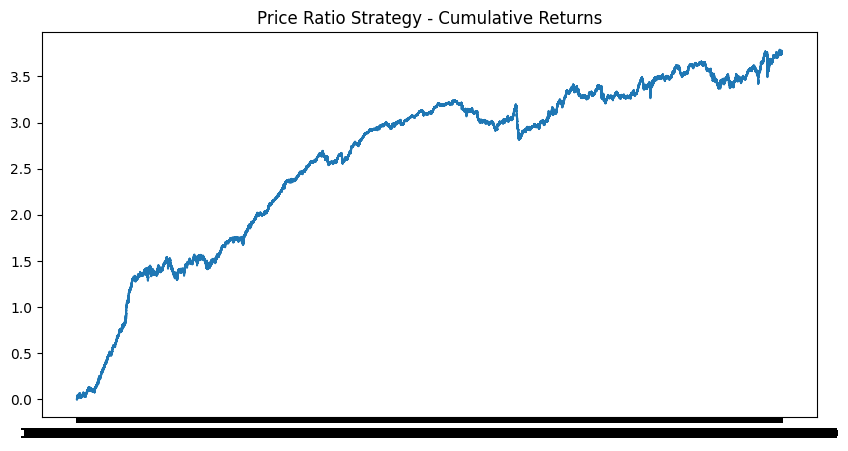

167295967

In [9]:
# 1) Price Ratio approach: ratio = BTC_Close / ETH_Close
combined['ratio'] = combined['BTC_Close'] / combined['ETH_Close']
combined['ratio_z'] = zscore(combined['ratio'], window=30)

# 2) For demonstration, we can create signals when ratio_z > 2 or < -2
# Then do a naive PnL calculation

def ratio_trading_signals(df, upper=2.0, lower=-2.0):
    df['signal_ratio'] = 0
    df.loc[df['ratio_z'] > upper, 'signal_ratio'] = -1  # BTC is expensive relative to ETH
    df.loc[df['ratio_z'] < lower, 'signal_ratio'] = 1   # BTC is cheap relative to ETH
    df['position_ratio'] = df['signal_ratio'].replace(to_replace=0, method='ffill')
    return df

combined = ratio_trading_signals(combined)
combined['ratio_change'] = combined['ratio'].pct_change()  # approximate daily ratio change
combined['ratio_pnl'] = combined['position_ratio'].shift(1) * combined['ratio_change']
combined['ratio_cumpnl'] = combined['ratio_pnl'].cumsum()

plt.figure(figsize=(10, 5))
plt.title("Price Ratio Strategy - Cumulative Returns")
plt.plot(combined.index, combined['ratio_cumpnl'])
plt.show()

gc.collect()

## 4. Adaptive Hedge Ratio with a Kalman Filter

A **Kalman filter** can dynamically estimate the changing relationship (hedge ratio) between BTC and ETH. Below is a simplified example using a custom-coded Kalman filter logic. (If you have `pykalman`, you can use that library’s `KalmanFilter` class instead.)

### 4.1 Simple Kalman Filter Implementation

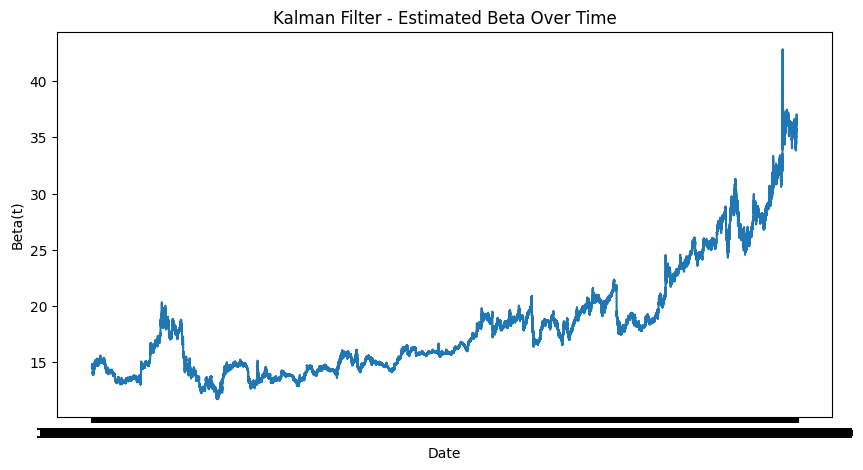

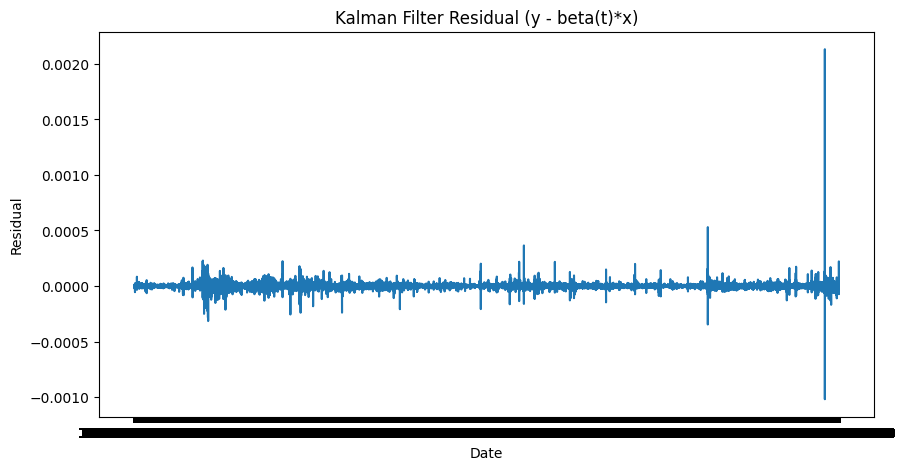

167295861

In [11]:
def kalman_filter(y, x):
    """
    A simple 2D Kalman filter to estimate an evolving beta for y ~ beta*x.
    Returns arrays of (beta, residual) at each time step.
    """
    n = len(y)
    beta_est = np.zeros(n)
    residual = np.zeros(n)
    
    # Initial guesses
    beta = 0.0
    P = 1.0  # covariance of beta estimate
    R = 0.001  # measurement noise
    Q = 0.001  # process noise (how fast beta can change)
    
    for i in range(n):
        # Predict step
        beta = beta  # no change in beta in the simplest model
        P = P + Q    # add process noise
        
        # Observe step
        # Measurement: y[i] = beta*x[i] + noise
        if x[i] != 0:
            K = P * x[i] / (x[i]*x[i]*P + R)  # Kalman gain
            beta = beta + K * (y[i] - beta*x[i])
            P = P - K * x[i] * P
            
            beta_est[i] = beta
            residual[i] = y[i] - beta*x[i]
        else:
            # If x[i] = 0, skip
            beta_est[i] = beta
            residual[i] = np.nan
    
    return beta_est, residual

# Apply to our data
y_data = combined['BTC_Close'].values
x_data = combined['ETH_Close'].values
beta_est, resid = kalman_filter(y_data, x_data)

combined['beta_kf'] = beta_est
combined['resid_kf'] = resid

plt.figure(figsize=(10, 5))
plt.title("Kalman Filter - Estimated Beta Over Time")
plt.plot(combined.index, combined['beta_kf'])
plt.xlabel("Date")
plt.ylabel("Beta(t)")
plt.show()

plt.figure(figsize=(10, 5))
plt.title("Kalman Filter Residual (y - beta(t)*x)")
plt.plot(combined.index, combined['resid_kf'])
plt.xlabel("Date")
plt.ylabel("Residual")
plt.show()

gc.collect()

### 4.2 Generating Kalman-Based Signals
We can compute a rolling z-score of `resid_kf` to decide trades:

C:\Users\Kenneth\AppData\Local\Temp\2\ipykernel_13188\736625229.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined['kf_resid_z'] = zscore(combined['resid_kf'].fillna(method='ffill'), window=30)
C:\Users\Kenneth\AppData\Local\Temp\2\ipykernel_13188\736625229.py:9: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  combined['kf_position'] = combined['kf_signal'].replace(to_replace=0, method='ffill').fillna(0)


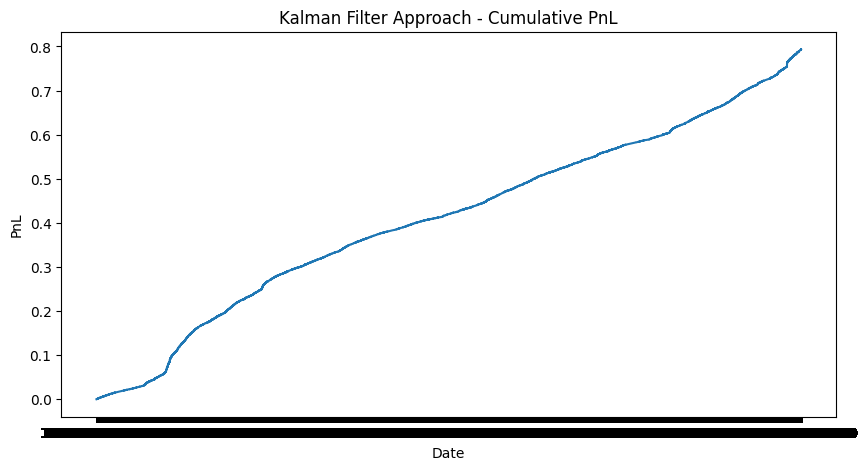

167296073

In [12]:
combined['kf_resid_z'] = zscore(combined['resid_kf'].fillna(method='ffill'), window=30)

entry_kf = 2.0
exit_kf = 0.5

combined['kf_signal'] = 0
combined.loc[combined['kf_resid_z'] > entry_kf, 'kf_signal'] = -1  # short spread
combined.loc[combined['kf_resid_z'] < -entry_kf, 'kf_signal'] = 1   # long spread
combined['kf_position'] = combined['kf_signal'].replace(to_replace=0, method='ffill').fillna(0)

# Simple PnL again
combined['kf_spread_change'] = combined['resid_kf'].diff()
combined['kf_pnl'] = combined['kf_position'].shift(1) * combined['kf_spread_change']
combined['kf_cumpnl'] = combined['kf_pnl'].cumsum()

plt.figure(figsize=(10, 5))
plt.title("Kalman Filter Approach - Cumulative PnL")
plt.plot(combined.index, combined['kf_cumpnl'])
plt.xlabel("Date")
plt.ylabel("PnL")
plt.show()

combined.drop(columns=['kf_signal','kf_position','kf_spread_change'], inplace=True)
gc.collect()

## Visualizations to Understand Results

Above we used basic `matplotlib` line plots. Some additional visualization tips:

- **Spread Overlays**: Plot the raw spread and a rolling mean ± 2 std dev to see visually how often it reverts.
- **Drawdown Plot**: Track the drawdown of your PnL.
- **Distribution Plots**: Show histograms of the spread or z-score to confirm it’s roughly normal/stationary.
- **Cumulative Returns**: The hallmark for evaluating strategy performance over time.

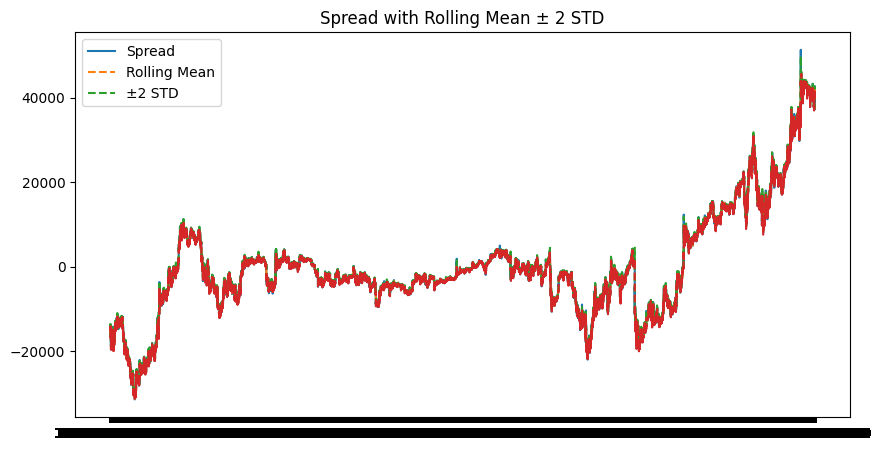

In [13]:
spread_mean = combined['spread'].rolling(30).mean()
spread_std = combined['spread'].rolling(30).std()

plt.figure(figsize=(10,5))
plt.plot(combined.index, combined['spread'], label='Spread')
plt.plot(combined.index, spread_mean, label='Rolling Mean', linestyle='--')
plt.plot(combined.index, spread_mean + 2*spread_std, linestyle='--', label='±2 STD')
plt.plot(combined.index, spread_mean - 2*spread_std, linestyle='--')
plt.title("Spread with Rolling Mean ± 2 STD")
plt.legend()
plt.show()
